## Project 2

Noni Arcilla

A14557003

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import string
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

### 1 Implementation

In [2]:
# constants
wall = 0 # refers to track boundary
tile = 1 # refers to racetrack 
start = 2 # refers to starting positions
finish = 2.5 # refers to finish line

### Create racetrack

In [14]:
def long_track():
    # create racetrack
    track = np.ones((50,50)) # grid of dimensions 50x50
    
    # start and finish line
    track[49, 1:11] = start
    track[1:7, 48] = finish
    
    # border
    track[:, 0] = wall
    track[0, :] = wall
    track[:, 49] = wall
    
    # create track boundaries (walls) - bottom part
    track[45:50, 11:] = wall
    track[35:40, :30] = wall
    track[40:42, 20:30] = wall
    track[30:35, :10] = wall
    track[39:42, 40:] = wall
    track[30:39, 36:] = wall

    # track boundaries - middle and top part
    track[25:30, 25:] = wall
    track[21:25, 32:] = wall
    track[7:11, 26:] = wall
    track[10:21, 44:] = wall

    # obstacles within grid
    track[22:26, 9:15] = wall
    track[18:22, 6:20] = wall
    track[14:18, 22:35] = wall
    track[15:20, 19:24] = wall
    #track[7:10, 40:44] = tile
    track[3:5, 35:40] = wall
    track[5:9, 15:20] = wall

    # wall on top left
    for i in range(1,15):
        track[i, 1:15-i] = wall
        
    return track

In [4]:
# FUNCTION - create racetrack
def create_track():
    # create racetrack
    track = np.ones((50,50)) # grid of dimensions 50x50
    
    # start and finish line
    track[49, 1:11] = start
    #track[1:7, 48] = finish
    
    # border
    track[:, 0] = wall
    track[0, :] = wall
    track[:, 49] = wall
    
    # create track boundaries (walls) - bottom part
    track[45:50, 11:] = wall
    track[35:40, :30] = wall
    track[40:42, 20:30] = wall
    track[30:35, :10] = wall
    track[39:42, 40:] = wall
    track[30:39, 36:] = wall
    track[42:45, 40:] = wall

    # track boundaries - middle and top part
    track[25:30, 25:] = wall
    track[21:25, 32:] = wall
    track[7:11, 26:] = wall
    track[10:21, 44:] = wall

    # obstacles within grid
    track[22:26, 9:15] = wall
    track[18:22, 6:20] = wall
    track[14:18, 22:35] = wall
    track[15:20, 19:24] = wall
    #track[7:10, 40:44] = tile
    track[3:5, 35:40] = wall
    track[5:9, 15:20] = wall

    # wall on top left
    #for i in range(1,15):
    #    track[i, 1:15-i] = wall
        
    # after checkpoint additions
    track[40:42, 20:30] = tile # bottom
    track[39:45, 36:40] = wall
    
    track[:11] = wall
    track[11:21, 43] = finish
        
        
    track = track[10:, :45]
    
    # wall on top left
    for i in range(1,8):
        track[i, 1:8-i] = wall
    track[30, :30] = wall
    track[:20, :11] = wall
    track[:8] = wall
    track[11:13, 32:44] = tile
    track[8:13, 43] = finish
    track[20:25, 10] = wall
    
    track = track[7:]
        
    return track

In [15]:
# FUNCTION - display racetrack
def display_track(track):
    fig, ax = plt.subplots(figsize=(50,50))
    sns.heatmap(track, annot=True, linewidths=.5, ax=ax)

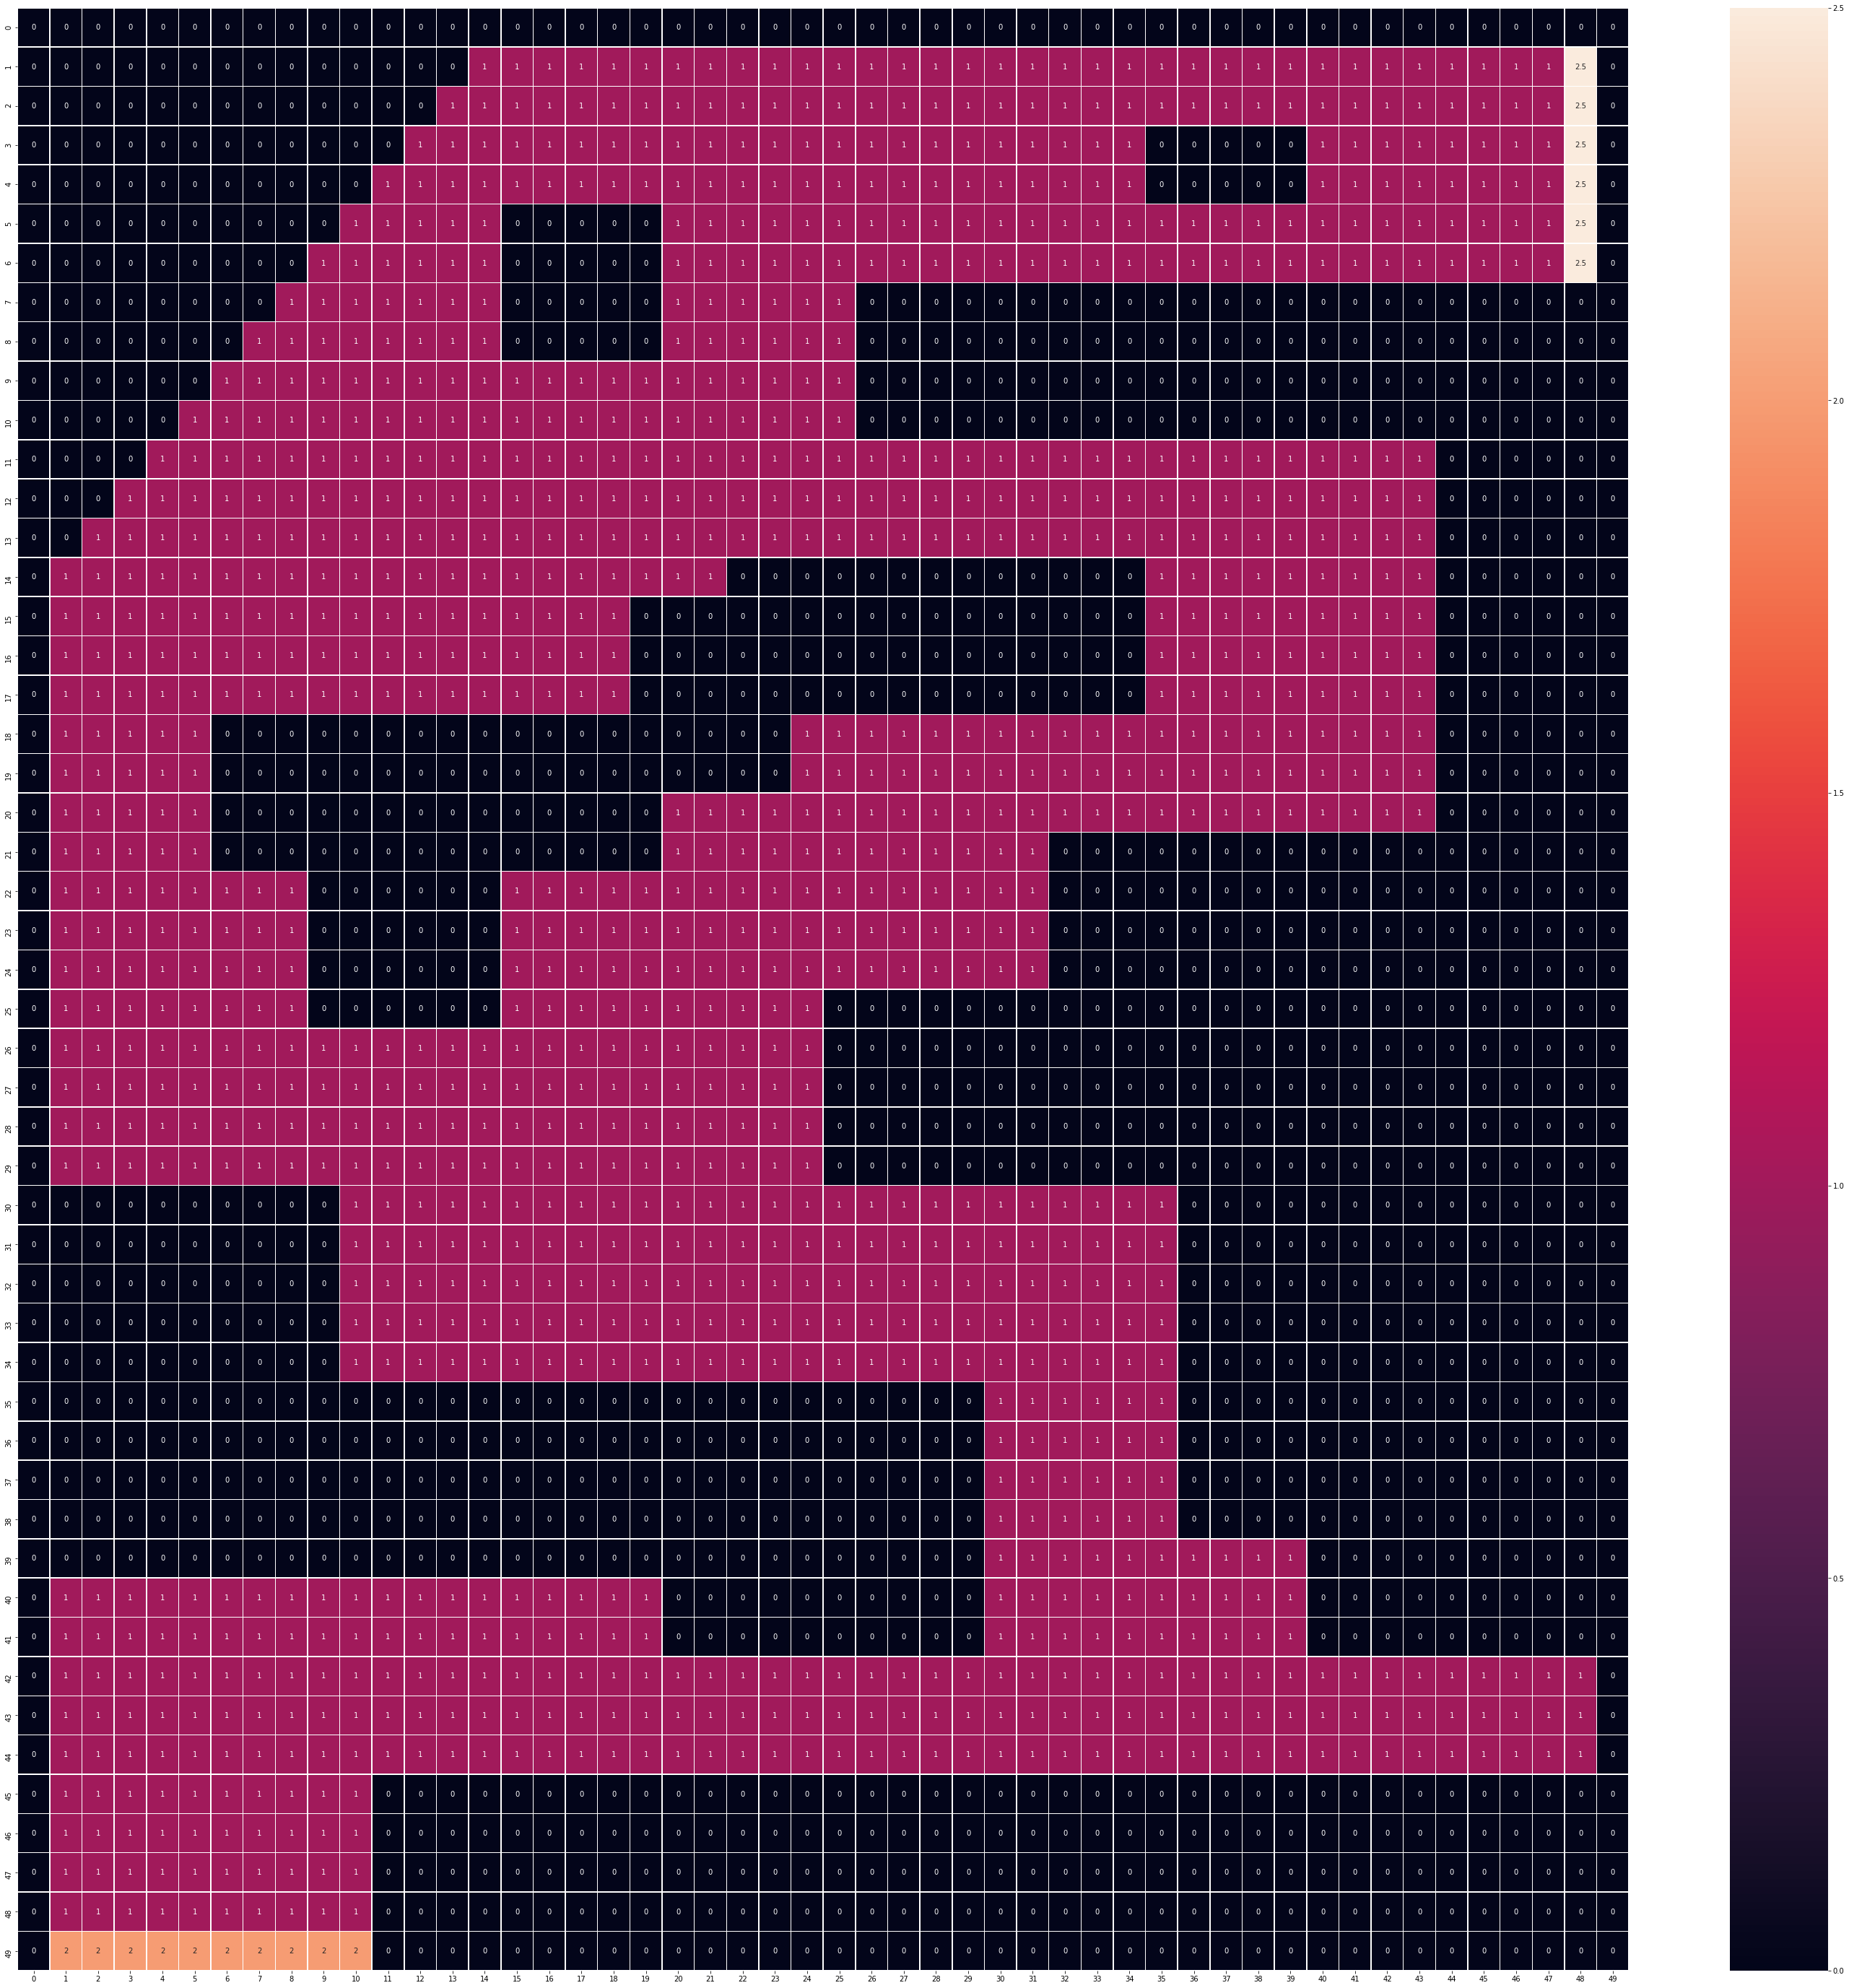

In [16]:
# Display racetrack
track = long_track()
display_track(track)

In [7]:
# FUNCTION - display trajectory of an episode
def create_trajectory(q, marker):
    rtrack = create_track()
    
    # starting position
    row = 49 #32
    col = random.choice(range(1,11))
    s = (row, col)
    
    # race through the board
    while s != 'T':
        # mark current position on the board
        row = s[0]
        col = s[1]
        rtrack[row][col] = marker
        
        # pick next action from position
        action_index = np.unravel_index(np.argmax(q[row][col]), q[row][col].shape)
        row_velocity, col_velocity = action_index[0]-4, action_index[1]-4 #velocities[action_index[0]], velocities[action_index[1]]
        s_prime, r = step(row, col, row_velocity, col_velocity)
        
        s = s_prime
        
    return rtrack

### Environment functions

In [12]:
def step(row, col, row_velocity, col_velocity):
    # assume that velocity components are >= -4 and < 5
    
    # new positions
    row_new = row + row_velocity
    col_new = col + col_velocity
    
    # terminal state condition - check if crossed finish line
    if row_new in range(1,7) and col_new >= 48:
        return 'T', -1
    
    # check out of bounds - return to starting position
    out_of_bounds = (row_new not in range(50)) or (col_new not in range(50))
    if out_of_bounds:
        return (row, col), -1
    
    # check if car hits a boundary - return to starting position
    hit_boundary = (track[row_new][col_new] == wall)
    if hit_boundary:
        return (row, col), -1
    
    # everything valid, so return new position
    return (row_new, col_new), -1

## Algorithms

Constants for both algorithms

In [3]:
# constants
n_rows = 50 #33
n_cols = 50 #45
start_row = 49 #32

num_vels = 9 # [-4, -3, -2, -1, 0, 1, 2, 3, 4]
velocities = [i for i in range(-4,5)]

### Q-learning

In [10]:
# FUNCTION - determine which action to use with epsilon-greedy
def choose_action(actions, eps):
    if np.random.random() > eps:
        action_index = np.unravel_index(np.argmax(actions), actions.shape)
        return velocities[action_index[0]], velocities[action_index[1]] # x-velocity, y-velocity
    else:
        return np.random.randint(-4,5), np.random.randint(-4,5)

In [11]:
# FUNCTION - perform q-learning (update q, so return nothing)
def qlearn(q, num_eps): # old - qlearn(q, eps, num_eps)
    N = np.zeros((n_rows, n_cols, num_vels, num_vels))

    for e in range(num_eps):
        # states are of the form (row, col)
        # actions are of the form (row_velocity, col_velocity), row_velocity means the velocity it moves in a column
        
        # begin in one of the positions on the starting line
        row = start_row
        col = random.choice(range(1,11))
        s = (row, col)
        
        # loop through each step of episode until car crosses finish line
        while s != 'T':
            eps = 10/(10+np.min(N[row][col])) # ADD
            a = choose_action(q[row][col], eps) # choose a from s
            s_prime, r = step(s[0], s[1], a[0], a[1]) # take action a
            
            #cur_Q = Q[x_pos][y_pos][x_velocity][y_velocity][a[0]][a[1]][a[2]][a[3]]
            
            # velocity indices
            row_vel_in = a[0] + 4
            col_vel_in = a[1] + 4
            
            # update N, determine alpha
            N[row][col][row_vel_in][col_vel_in] += 1 # ADD
            alpha = 1/N[row][col][row_vel_in][col_vel_in] # ADD
            
            # Q-learning
            cur_Q = q[row][col][row_vel_in][col_vel_in]
            if s_prime == 'T':
                cur_Q += alpha * (r - cur_Q)
            else:
                cur_Q += alpha * (r + np.max(q[row][col]) - cur_Q)
            q[row][col][row_vel_in][col_vel_in] = cur_Q
            
            # s = s'
            s = s_prime
            if s != 'T':
                row = s[0]
                col = s[1]

In [12]:
# find Q*
Q = np.zeros((n_rows, n_cols, num_vels, num_vels)) # row, col, row-velocity, col-velocity
n_eps = 50000
qlearn(Q, n_eps)

In [22]:
# FUNCTION - return and display value function
def display_vf(q):
    # find V*
    V = np.zeros((n_rows, n_cols))
    for row_i, row in enumerate(V):
        for col_i, col in enumerate(row):
            # check if position is a wall
            if track[row_i][col_i] == wall:
                V[row_i][col_i] = 0
            else:
                V[row_i][col_i] = np.max(q[row_i][col_i])

    display_track(V)
    #
    #return V

In [14]:
# FUNCTION - find optimal policy
def display_policy(q):
    policy = []
    for row_i, row in enumerate(q):
        cur_row = []
        for col_i, col in enumerate(row):
            # check if position is a wall
            if track[row_i][col_i] == wall:
                cur_row.append(0)
            else:
                a = np.unravel_index(np.argmax(q[row_i][col_i]), q[row_i][col_i].shape)
                cur_row.append((a[0],a[1]))
        policy.append(cur_row)
    
    return policy

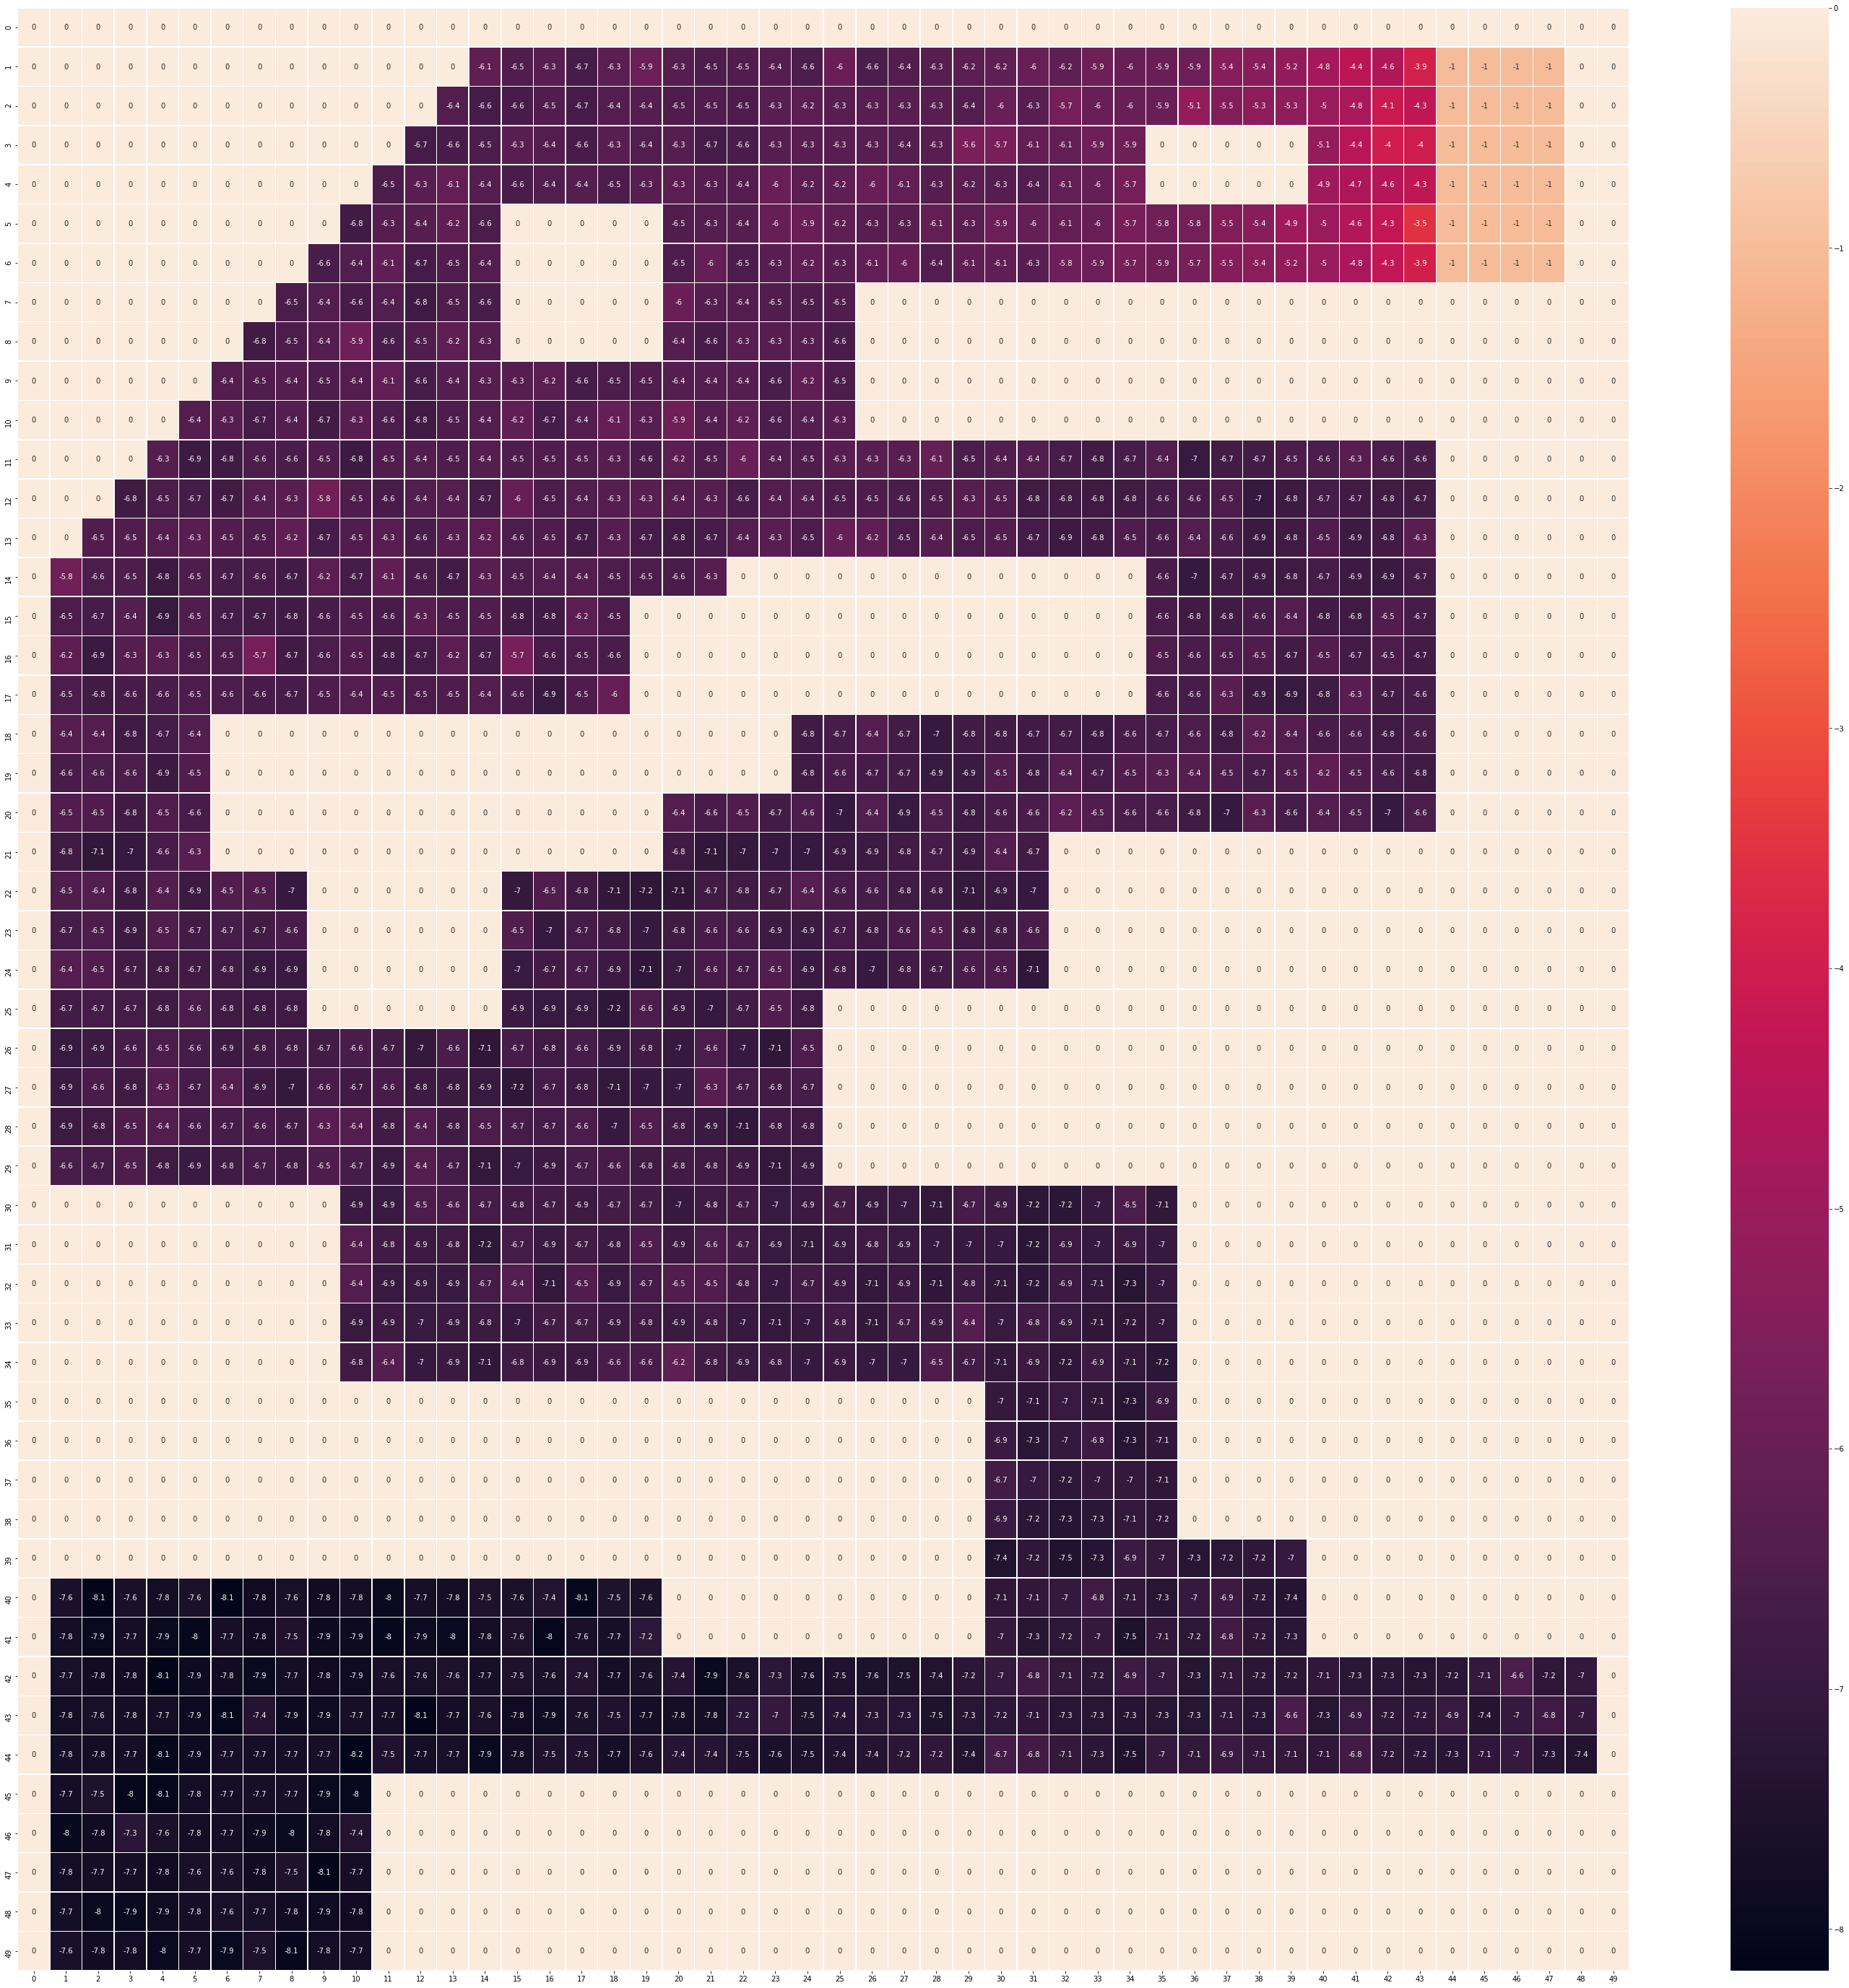

In [15]:
# display value function
# TODO
display_vf(Q)

In [ ]:
# display sample trajectory
#tr = create_trajectory(Q, 5)
#display_track(tr)
display_policy(Q)

### n-step Sarsa

In [19]:
# FUNCTION - run n-step SARSA
def nstepsarsa(q, n, num_eps):
    N = np.zeros((n_rows, n_cols, num_vels, num_vels))
    for j in range(num_eps):
        episode = []
        actions = []
        
        # s0, a0
        s = (start_row, random.choice(range(1,11))) # row, col
        eps = 10/(10+np.min(N[s[0]][s[1]])) # ADD
        a = choose_action(q[s[0]][s[1]], eps)
        
        # store (reward,state) and actions in the lists
        episode.append((0,s))
        actions.append(a)
        
        T = 100000
        t = 0
        tau = 0
        
        while tau != T-1:
            if t < T:
                # take action, observe and store next reward/state
                s_prime, r = step(s[0], s[1], a[0], a[1])
                episode.append((r, s_prime))
                
                # terminal state condition - check if crossed finish line
                if s_prime == 'T':
                    T = t+1
                else:
                    # select and store action a_t+1
                    eps = 10/(10+np.min(N[s_prime[0]][s_prime[1]])) # ADD
                    a = choose_action(q[s_prime[0]][s_prime[1]], eps)
                    actions.append(a)
                    
                s = s_prime
            
            # time step in which the state is updated - reaches >= 0 after n steps
            tau = t-n+1
            
            # update Q-values
            if tau >= 0:
                # add rewards
                G = 0
                for l in range(tau+1, min(tau+n,T)+1):
                    G += episode[l][0]
                
                # bootstrap
                if tau+n < T:
                    b = episode[tau+n][1] # b is a state = (row, col)
                    cur_action = actions[tau+n]
                    G += q[b[0]][b[1]][cur_action[0]][cur_action[1]]
                    
                # update value of action at time tau
                s_tau = episode[tau][1]
                a_tau = actions[tau]
                cur_Q = q[s_tau[0]][s_tau[1]][a_tau[0]][a_tau[1]]
                
                # update N, determine alpha
                N[s_tau[0]][s_tau[1]][a_tau[0]][a_tau[1]] += 1 # ADD
                alpha = 1/N[s_tau[0]][s_tau[1]][a_tau[0]][a_tau[1]] # ADD
                
                cur_Q += alpha * (G - cur_Q)
                q[s_tau[0]][s_tau[1]][a_tau[0]][a_tau[1]] = cur_Q
                
            t += 1

In [20]:
# find Q*
# TODO
Q = np.zeros((n_rows, n_cols, num_vels, num_vels))
n_eps = 50000
nstepsarsa(Q, 4, n_eps)

KeyboardInterrupt: ignored

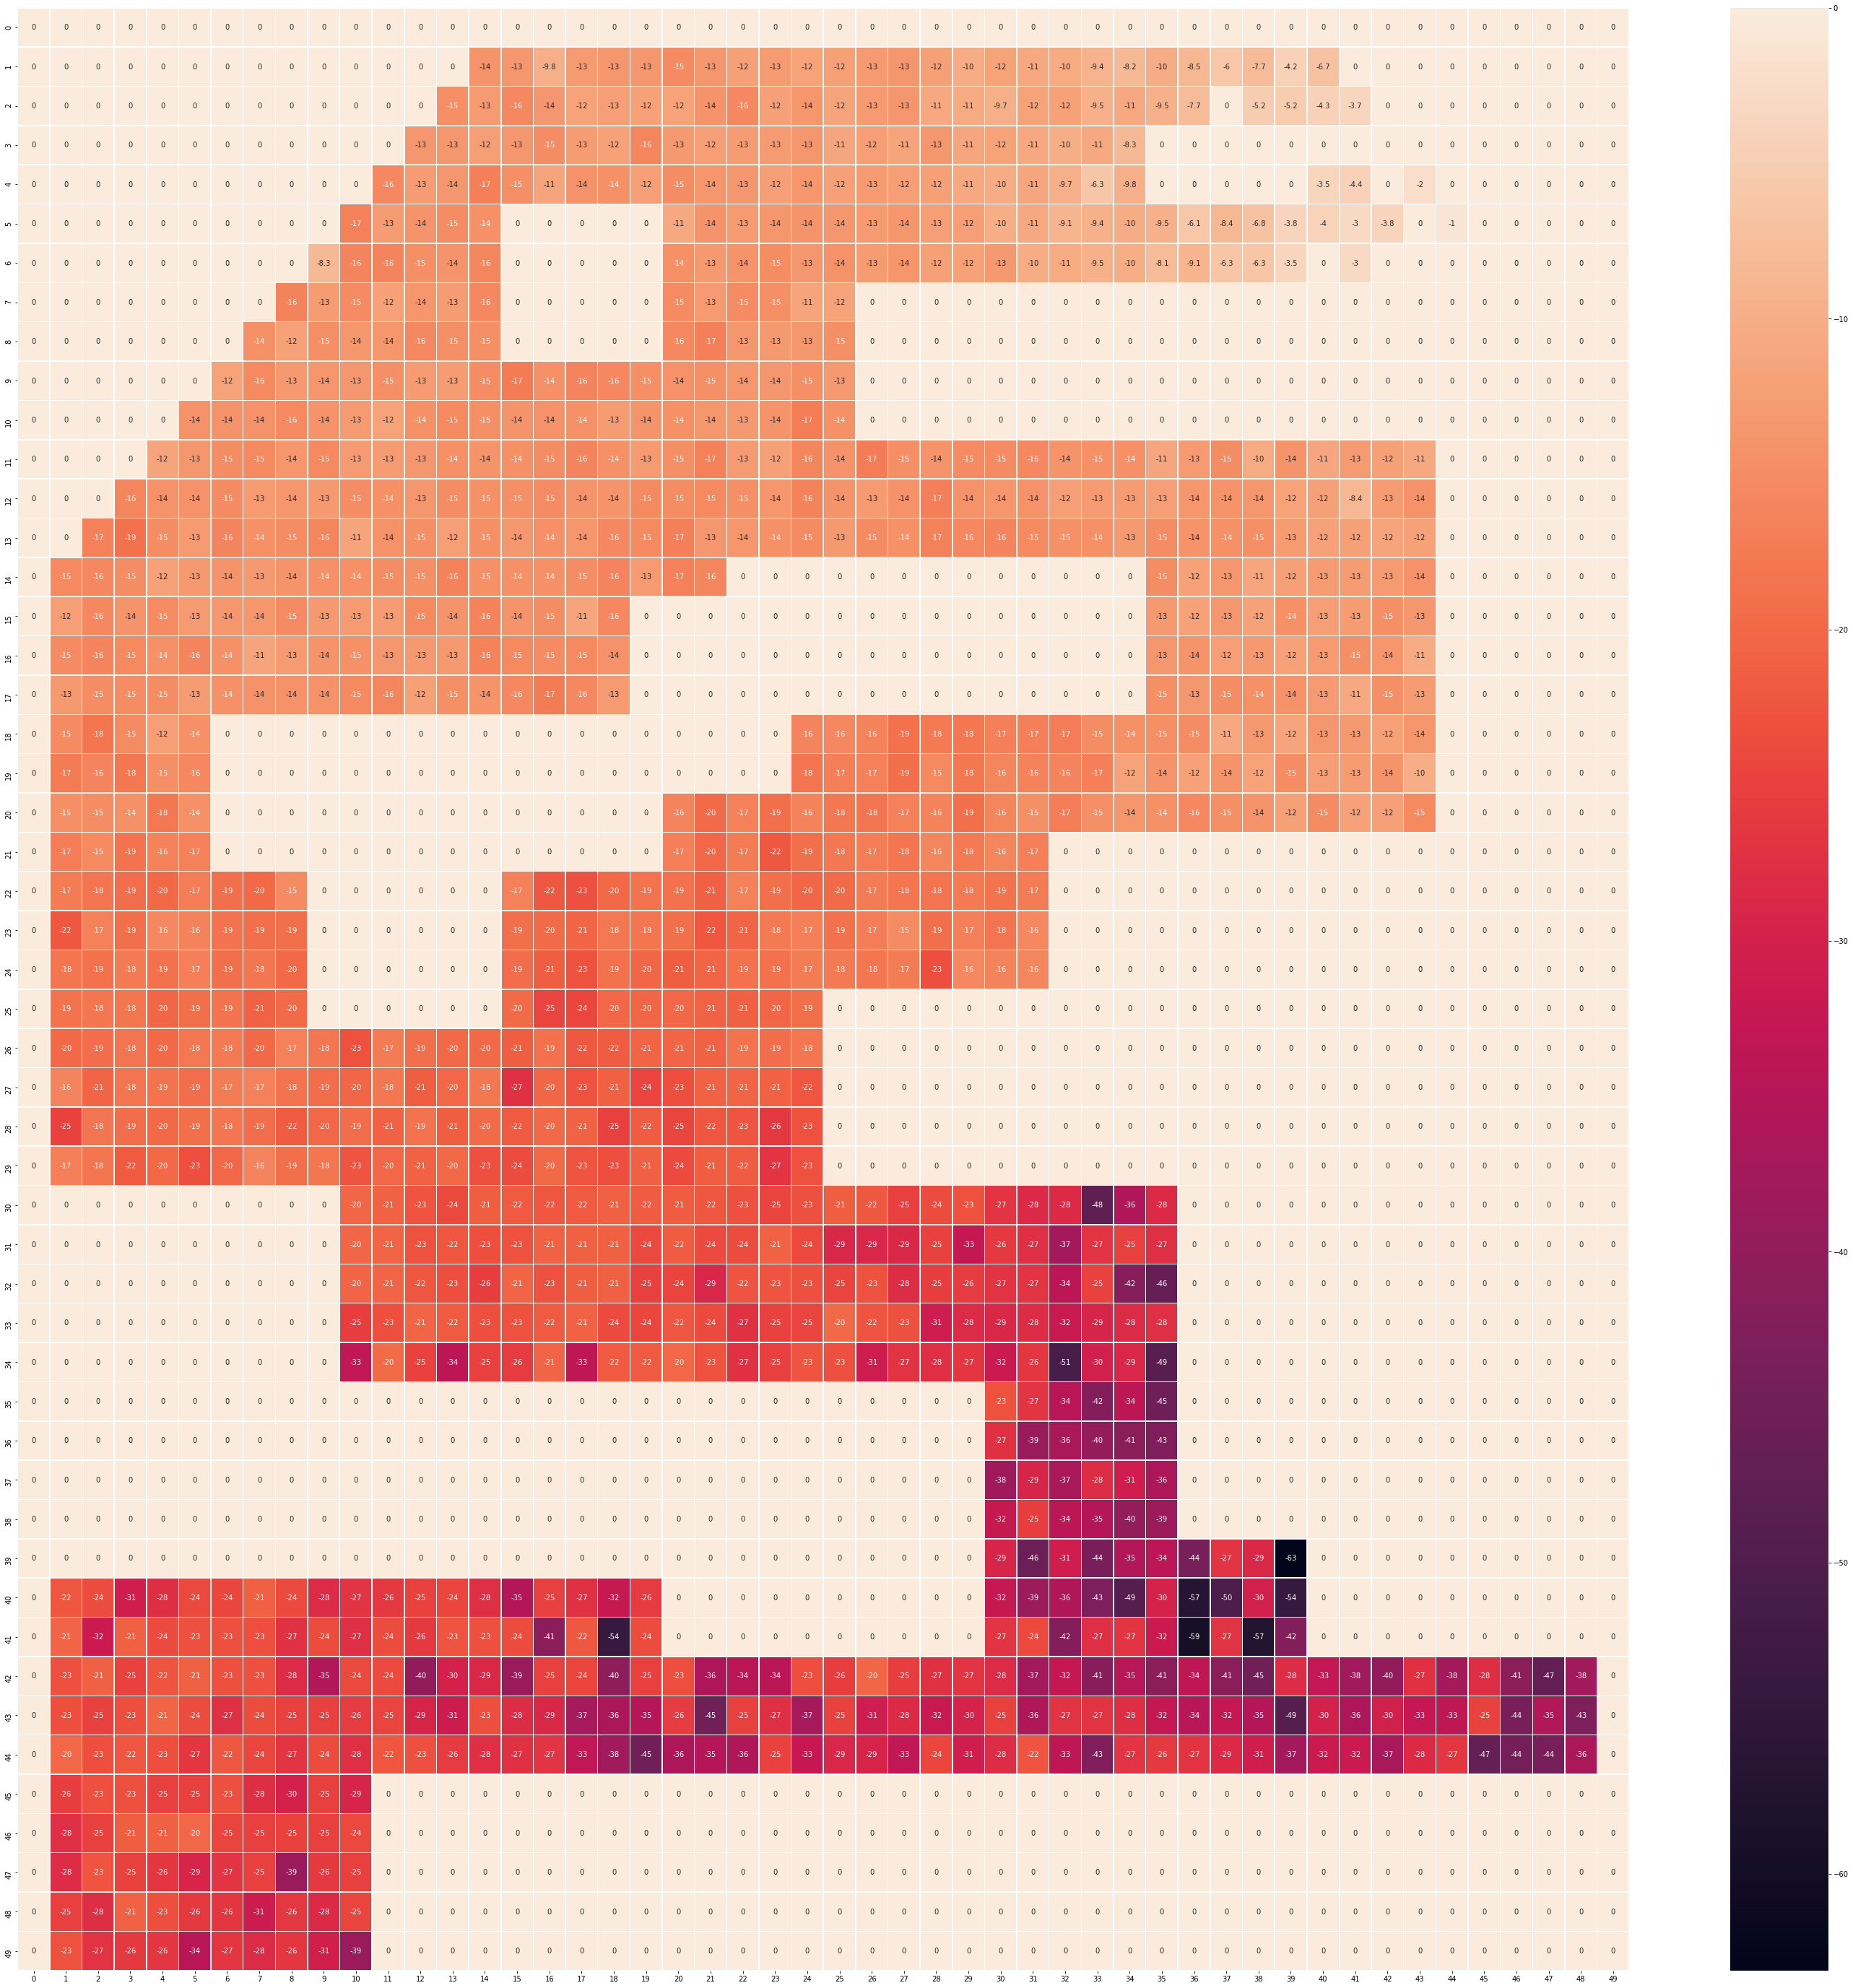

In [23]:
# find and display value function
display_vf(Q)

In [ ]:
# display sample trajectory
tr = create_trajectory(Q, 5)
display_track(tr)